In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import json
import seaborn as sns
from scipy.stats import t
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
from itertools import combinations

previous_time = time.time()

In [19]:
# Uncomment these lines to access the winners for the given edition year for a given sport 

# with open("compress_data/sports_matches_data.json") as file: 
#     matches_data = json.load(file)
    
# sport = 'soccer'
# year = '2014'
# matches_data[sport][year]['winner']

In [20]:
# Uncomment these lines to access the team ranking for the given edition year for a given sport 

# with open("compress_data/sports_ranking_data.json") as file: 
#     ranking_data = json.load(file)
    
# sport = 'soccer'
# year = '2014'
# ranking_data[sport][year]["ranked_players"]

In [21]:
class SportsPopularity:
    """
    Class used to perform statistical analysis on the underdog achievement in the team ball sports included in the paper:
    "Why is soccer so popular: Understanding underdog achievement and randomness in team ball sports"

    Attributes
        cutoff (real):               Segmentation percentage (default 0.5).
        threshold (dict):            Dictionary where the keys are sports and the items are rank difference thresholds to consider a team as weak.
        decay_factor (real):         Decay factor for weighted ranking (default 0.5). Dictates the rate at which the team scores for past years become irrelevant.
        actual_ranking (bool):       A flag to use the actual_ranking for soccer (default False).
        iprint (int):                Used to print info (default 1): 0 --> no printing; >=1 --> printing. 
    """    
    
    def __init__(self, cutoff, threshold, decay_factor=0.5, actual_ranking=False, iprint = 1):
        self.cutoff = cutoff
        self.threshold = threshold
        self.decay_factor = decay_factor
        self.actual_ranking = actual_ranking
        self.iprint = iprint
        
        
    def read_ranking(self): 
        """
        Reads the team rankings for each edition of the competitions selected for each sport and returns the json object ranking_data from sports_ranking_data.json. 
        """
        with open("compress_data/sports_ranking_data.json") as file: 
            ranking_data = json.load(file)

        return ranking_data
       
        
    def read_matches(self):
        """
        Reads the matches for all sports and returns the json object matches_data from sports_matches_data.json.
        """
        with open("compress_data/sports_matches_data.json") as file: 
            matches_data = json.load(file)

        return matches_data
    

    def compute_weighted_ranking_list(self, sport, ranking_data, year, weighted_rank):
        """
        Creates the weighted ranking list (denoted ranked_list), which weights all the team rankings across the edition years.
        The weighted ranking contains teams in decreasing order (the top is the best). The importance of team scores for past years is decreased by using a decay factor.
        """ 
        year_list = list(ranking_data[sport].keys())
        ranked_list = []

        # Read the ranking
        current_rank = ranking_data[sport][year]["ranked_players"]

        for i in range(len(current_rank)):
            p_score = 0
            # For the ranking in first year, we do not need to weight past rankings
            if year == year_list[0]:
                player = current_rank[i]
                scores = len(current_rank)-i
                weighted_rank.update({player: scores})
            else:
                player = current_rank[i]
                if player in weighted_rank:
                    p_score = weighted_rank[player]
                scores = len(current_rank)-i + (p_score * self.decay_factor)
                weighted_rank.update({player: scores})

        # We want the top in the ranking to be the best
        sorted_dict = dict(sorted(weighted_rank.items(), key=lambda item: item[1], reverse=True))
        ranked_list = list(sorted_dict.keys())
        
        return ranked_list
    
    
    def compute_uas_cutoff(self, sport, ranked_list, matches_data, year):
        """
        Uses the cutoff strategy to compute p_chart_list = [weak win count, total matches with a weak team] and probability = UAS.
        """
        segmentation_percentage = self.cutoff
        num_countries = len(ranked_list)
        top_index = round(segmentation_percentage * num_countries)
#         top_index = 1 # If 1, only consider past champions; if 4, only consider semi-finalists
        bottom_index = round(num_countries - top_index)
        
        weak_win_count = 0
        year = str(year)

        if self.iprint >= 2:           
            print('Year',year)
            
        # player1s holds all the players as a list for the [sport] in the [year] 
        player1s = matches_data[sport][year]["player1"]
        player2s = matches_data[sport][year]["player2"]
        winners = matches_data[sport][year]["winner"] 
        
        for i in range(len(player1s)): 
            player1 = player1s[i].strip()
            player2 = player2s[i].strip()
            winner = winners[i].strip()

            # Filter the players not in the list and prevent them from counting towards UAS 
            if player1 not in ranked_list:
                ranked_list.append(player1)
            if player2 not in ranked_list:
                ranked_list.append(player2)
            
            top_list = ranked_list[:top_index]
            bottom_list = ranked_list[bottom_index:]
            
            # Separate the weak teams from the strong ones and update weak_win_count
            if player1 in top_list and player2 in bottom_list and winner in bottom_list:
                weak_win_count += 1
            if player1 in bottom_list and player2 in top_list and winner in bottom_list:
                weak_win_count += 1 
                
            if self.iprint >= 2:                        
                print('Match',i,'WWC',weak_win_count,'P1',player1,'P2',player2,'W',winner,'Bottom?',(winner in bottom_list))                
        
        if weak_matches_count == 0:
            weak_matches_count = 1
        probability = weak_win_count / weak_matches_count # UAS
        p_chart_list = [weak_win_count, weak_matches_count] 
        
        return p_chart_list, probability

    
    def compute_uas_1v1(self, sport, ranked_list, matches_data, year):
        """
        Uses the 1v1 strategy to compute p_chart_list = [weak win count, total matches with a weak team] and probability = UAS.
        """
        weak_win_count = 0
        weak_matches_count = 0
        year = str(year)

        if self.iprint >= 2:           
            print('\nYear',year)

        # player1s holds all the players as a list for the [sport] in the [year] 
        player1s = matches_data[sport][year]["player1"]
        player2s = matches_data[sport][year]["player2"]
        winners = matches_data[sport][year]["winner"]

        for i in range(len(player1s)): 
            player1 = player1s[i].strip()
            player2 = player2s[i].strip()
            winner = winners[i].strip()
            weak_player = ""

            # Filter the players not in the list and prevent them from counting towards UAS 
            if player1 not in ranked_list:
                player1_rank = len(ranked_list)
            else: 
                player1_rank = ranked_list.index(player1)
                
            if player2 not in ranked_list:
                player2_rank = len(ranked_list)
            else: 
                player2_rank = ranked_list.index(player2)

            # Clean the data and keeps matches where rank different >= threshold 
            # Data with rank difference < threshold is classified as noisy data 
            rank_diff = abs(player1_rank - player2_rank)
            
            weak_win_count_prev = weak_win_count
            
            if rank_diff >= self.threshold[sport]:
                weak_matches_count += 1
                
                if player1_rank > player2_rank:
                    weak_player = player1
                    # Selects the winners who are weaker or result in a draw for UAS
                    if weak_player == winner or winner == "Draw":
                        weak_win_count += 1
                        
                if player2_rank > player1_rank:
                    weak_player = player2
                    if weak_player == winner or winner == "Draw":
                        weak_win_count += 1 
                        
            if self.iprint >= 2:
                # Uncomment if you want to print all matches
#                 print('Match',i,'WWC',weak_win_count,'P1',player1,'P2',player2,'W',winner,'WP',weak_player)
                # Uncomment if you only want to print matches that contribute to the UAS
                if weak_win_count > weak_win_count_prev: # Only prints the matches 
                    print('P1:',player1,' P2:',player2,' W:',winner,' WP:',weak_player)
                
        if weak_matches_count == 0:
            weak_matches_count = 1
        probability = weak_win_count / weak_matches_count # UAS
        p_chart_list = [weak_win_count, weak_matches_count]        

        if self.iprint >= 1:
            print('Sport: ',sport,', UAS: ',probability,', Win Weak Count: ',p_chart_list[0],', Total Matches: ',p_chart_list[1])

        return p_chart_list, probability   
    

    def main(self, sport, year_m, year_r, strategy, matches_data, ranking_data, weighted_rank, ranking_method="normal"):
        """
        Uses the 1v1 strategy to return p_chart_list = [weak win count, total matches with a weak team] and probability = UAS for a given sport for matches in year year_m with ranking in year year_r.
        If year_r has more than one element, the rankings over past years will be weighted into a weighted ranking.
        The strategy argument can be either "cutoff" or "1v1".

        Attributes
            sport (string):  Name of the sport
            year_r (int):    List of years for the rankings
            year_m (string): Year of the matches
        """
        if ranking_method == "normal":
            ranked_list = ranking_data[sport][str(year_r)]["ranked_players"]
        else: 
            ranked_list =  self.compute_weighted_ranking_list(sport, ranking_data, year_m, weighted_rank)

        if strategy=="cutoff":
            p_chart_list, probability = self.compute_uas_cutoff(sport, ranked_list, matches_data, year_m)
            pass 
        elif strategy=="1v1":
            p_chart_list, probability = self.compute_uas_1v1(sport, ranked_list, matches_data, year_m)            
            
        return p_chart_list, probability  
    

    def draw_pcharts(self, subgroup_sizes, defective_counts, x_labels):
        """
        Draws Laney p'-charts.

        Attributes
            subgroup_sizes (list):   List of subgroup sizes
            defective_counts (list): List of defective counts
            x_labels (list):         List of labels for x axis
        """

        def calculate_control_limits(proportions, subgroup_sizes):
            center_line = np.mean(proportions)
            std_errors = np.sqrt(center_line * (1 - center_line) / subgroup_sizes)
            Z = (proportions - center_line) / std_errors
            MR = sum([abs(proportions[i] - proportions[i-1]) for i in range(1, len(proportions))]) / (len(proportions) - 1)
            std_Z = MR / 1.128
            ucl = center_line + 3 * std_errors * std_Z
            lcl = center_line - 3 * std_errors * std_Z
            return ucl, lcl

        proportions = defective_counts / subgroup_sizes
        print('\n Proportions for Laney p-charts: ', proportions)

        # Calculate control limits
        ucl, lcl = calculate_control_limits(proportions, subgroup_sizes)

        # Plot p-chart
        plt.figure(figsize=(10, 5))
        plt.plot(proportions, marker='o', linestyle='-')
        plt.axhline(np.mean(proportions), color='red', linestyle='--', label='Center Line')
        plt.plot(ucl, linestyle='--', color='green', label='UCL')
        plt.plot(lcl, linestyle='--', color='green', label='LCL')

        # Draw dashed lines from each data point to the x-axis
        for i, prop in enumerate(proportions):
            plt.vlines(i, 0, prop, colors='gray', linestyles='--', alpha=0.2)

        title_string = r"$\lambda = $" + str(self.decay_factor)
        plt.title(title_string, fontsize=20)
        plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha="right", fontsize=14) 
        title_string = r"$\overline{UAS}$" 
        plt.ylabel(title_string, fontsize=18, labelpad=10)
        plt.legend()
        plt.show()

    
    def draw_UAS_boxplots(self, sports, uas_dict, x_labels):
        """
        Draws boxplots of UAS for each sport.
        
        Attributes
            sports (list): List of sports names
            uas_dict (list): Dictionary with as many elements as the number of sports
            x_labels (list): List of labels for x axis
        """
        
        figure = plt.figure(figsize=(15,7))

        sports_labels = ['Basketball','Cricket','Field Hockey','Futsal','Handball','Ice Hockey','Lacrosse','Roller Hockey','Rugby','Soccer','Volleyball','Water Polo']
        
        boxplot = plt.boxplot([uas_dict[sport] for sport in sports], patch_artist=True, labels = sports_labels)
        
        title_string = r"UAS$_{e_h}$"
        plt.ylabel(title_string, fontsize=18, labelpad=10)

        title_string = r"$\lambda = $" + str(self.decay_factor)
        plt.title(title_string, fontsize=20)        
        
        # Increase the font size of the labels
        plt.xticks(rotation=45, ha="right", fontsize=14)

        plt.plot()

    
    def draw_UAS_ci(self, sports, uas_dict, x_labels):
        """
        Draws confidence intervals for mean UAS for each sport.

        Attributes
            sports (list): List of sports names
            uas_dict (list): Dictionary with as many elements as the number of sports
            x_labels (list): List of labels for x axis
        """

        figure = plt.figure(figsize=(15,7))

        sports_labels = ['Basketball','Cricket','Field Hockey','Futsal','Handball','Ice Hockey','Lacrosse','Roller Hockey','Rugby','Soccer','Volleyball','Water Polo']

        # Calculate mean and standard error for each sport
        means = [np.mean(uas_dict[sport]) for sport in sports]
        std_errs = [np.std(uas_dict[sport], ddof=1) / np.sqrt(len(uas_dict[sport])) for sport in sports]

        # Calculate t-student confidence intervals
        conf_intervals = [t.interval(0.95, len(uas_dict[sport])-1, loc=mean, scale=std_err) for mean, std_err in zip(means, std_errs)]

        for i, (mean, conf_interval) in enumerate(zip(means, conf_intervals)):
            plt.plot([i, i], [conf_interval[0], conf_interval[1]], color='black', linewidth=1)  # Plot vertical lines
            plt.plot([i-0.1, i+0.1], [conf_interval[0], conf_interval[0]], color='black') # Plotting horizontal lines
            plt.plot([i-0.1, i+0.1], [conf_interval[1], conf_interval[1]], color='black') # Plotting horizontal lines
            plt.plot(i, mean, marker='o', markersize=5, color='red')  # Change color and marker style if needed

        title_string = r"UAS" 
        plt.ylabel(title_string, fontsize=18, labelpad=10)

        title_string = r"$\lambda = $" + str(self.decay_factor)
        plt.title(title_string, fontsize=20)        

        plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha="right", fontsize=14)

        plt.show()
 

    def perform_stat_tests(self, sports, uas_dict):
        """
        Perform statistical tests.

        Parameters:
            sports (list): List of sports names
            uas_dict (dict): Dictionary containing UAS data for each sport
        """
        
        ####### Perform Kruskal-Wallis test
        kw_results = kruskal(*[uas_dict[sport] for sport in sports])

        # Output the results
        print("\nKruskal-Wallis test results:")
        print("Statistic:", kw_results.statistic)
        print("p-value:", kw_results.pvalue)
        
        ####### Post hoc Dunn's test with Bonferroni correction
        dunn_result = posthoc_dunn([uas_dict[sport] for sport in sports], p_adjust='bonferroni')
        
        # Rename the indices and columns using the sport names
        dunn_result.index = sports
        dunn_result.columns = sports

        # Print pairwise comparison results
        print("\nPairwise Dunn's test results with Bonferroni correction:")
        print(dunn_result)

        # Example interpretation of Dunn's test results
        for group1 in dunn_result.index:
            for group2 in dunn_result.columns:
                if group1 != group2:
                    p_value = dunn_result.loc[group1, group2]
                    if p_value < 0.05:
                        print(f"{group1} and {group2} are significantly different (p-value = {p_value})")
                    else:
                        print(f"No significant difference between {group1} and {group2} (p-value = {p_value})")



    
    def plots(self, strategy="1v1", wranking=False, write_file=False):
        """
        If write_file is equal to True, creates a "sport + _pchart_[Name of the strategy].xlsx" file within the
        "PCharts Sheets" folder that contains: Year, Weak Win Count, Total Matches. 
        The strategy argument can be either "cutoff" or "1v1".
        """
        matches_data = self.read_matches()
        ranking_data = self.read_ranking()
        sports = list(matches_data.keys()) 

        total_weak_win_count = [] # list with as many elements as the number of sports
        total_weak_matches_count = [] # list with as many elements as the number of sports
        
        uas_dict = {} # dictionary with as many elements as the number of sports

        for sport in sports:
            weak_win_count = []
            total_weak_matches = []
            weak_win_count = []
            uas = [] 
            weighted_rank = {}
            years = list(matches_data[sport].keys())

            for i in range(len(years)):
                if years[i] == years[0]:
                    pass 
                    
                else:
                    if wranking: 
                        out = self.main(sport, years[i], years[i-1], strategy, matches_data, ranking_data, weighted_rank, "Wranking") 
                    else: 
                        out = self.main(sport, years[i], years[i-1], strategy, matches_data, ranking_data, weighted_rank) 

                    weak_win_count.append(out[0][0])
                    total_weak_matches.append(out[0][1])
                    uas.append(out[1])
            
            if self.iprint >= 1:    
                print('Mean UAS across all editions:', sum(uas)/len(uas),'\n')
              
            uas_dict[sport] = uas
            
            total_weak_win_count.append(sum(weak_win_count))
            total_weak_matches_count.append(sum(total_weak_matches))

        if write_file:
            data = {
                "Sport": sports, 
                "Weak Win Count": total_weak_win_count,
                "Total Matches": total_weak_matches_count,
            }
            df = pd.DataFrame(data)
            if strategy=="cutoff":
                df.to_excel(f"../exports/pchart_cutoff.xlsx", index=False)
            elif strategy=="1v1":
                df.to_excel(f"../exports/pchart_1v1.xlsx", index=False)
        
        self.draw_pcharts(subgroup_sizes = np.array(total_weak_matches_count),\
                        defective_counts = np.array(total_weak_win_count),\
                        x_labels=['Basketball','Cricket','Field Hockey','Futsal','Handball','Ice Hockey','Lacrosse','Roller Hockey','Rugby','Soccer','Volleyball','Water Polo'])            

        self.draw_UAS_boxplots(sports, uas_dict=uas_dict,\
                        x_labels=['Basketball','Cricket','Field Hockey','Futsal','Handball','Ice Hockey','Lacrosse','Roller Hockey','Rugby','Soccer','Volleyball','Water Polo'])           

        self.draw_UAS_ci(sports, uas_dict=uas_dict,\
                        x_labels=['Basketball','Cricket','Field Hockey','Futsal','Handball','Ice Hockey','Lacrosse','Roller Hockey','Rugby','Soccer','Volleyball','Water Polo'])           

        self.perform_stat_tests(sports, uas_dict)

# Underdog achievement analysis

In [22]:
# Parameters
cutoff_val = 0.5

threshold_val = {'basketball': 4, 'cricket': 4, 'field_hockey':4, 'futsal':5,\
                 'handball':4, 'ice_hockey':3, 'lacrosse':4, 'roller_hockey':5,\
                 'rugby':5, 'soccer':7, 'volleyball':4, 'water_polo':2.5} 

decay_factor_val = 1 #0.5 #0

In [23]:
sp = SportsPopularity(cutoff=cutoff_val, threshold=threshold_val, decay_factor=decay_factor_val, iprint=1)

Sport:  basketball , UAS:  0.0 , Win Weak Count:  0 , Total Matches:  41
Sport:  basketball , UAS:  0.15217391304347827 , Win Weak Count:  7 , Total Matches:  46
Sport:  basketball , UAS:  0.21875 , Win Weak Count:  7 , Total Matches:  32
Sport:  basketball , UAS:  0.35714285714285715 , Win Weak Count:  15 , Total Matches:  42
Sport:  basketball , UAS:  0.25 , Win Weak Count:  10 , Total Matches:  40
Sport:  basketball , UAS:  0.3142857142857143 , Win Weak Count:  11 , Total Matches:  35
Sport:  basketball , UAS:  0.3620689655172414 , Win Weak Count:  21 , Total Matches:  58
Sport:  basketball , UAS:  0.23529411764705882 , Win Weak Count:  8 , Total Matches:  34
Sport:  basketball , UAS:  0.25806451612903225 , Win Weak Count:  8 , Total Matches:  31
Sport:  basketball , UAS:  0.3333333333333333 , Win Weak Count:  11 , Total Matches:  33
Sport:  basketball , UAS:  0.2727272727272727 , Win Weak Count:  6 , Total Matches:  22
Mean UAS across all editions: 0.25034915362054444 

Sport:  cri

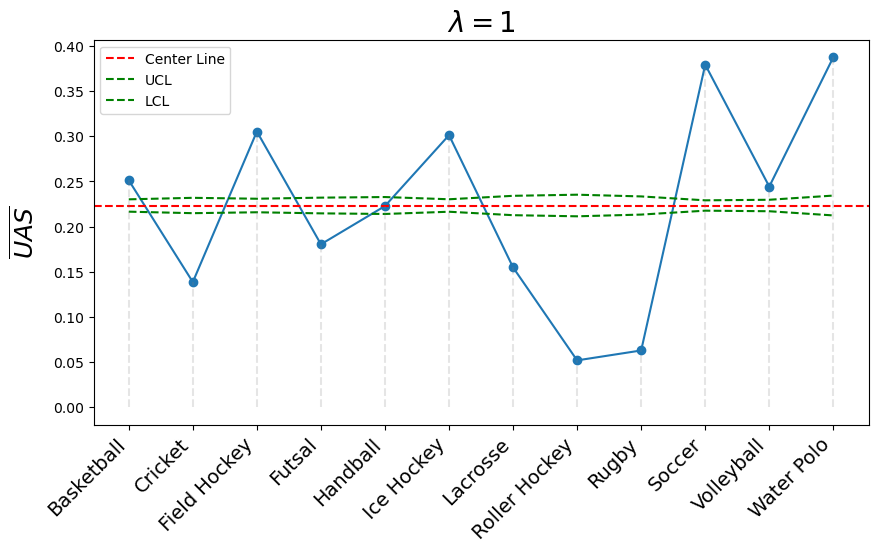

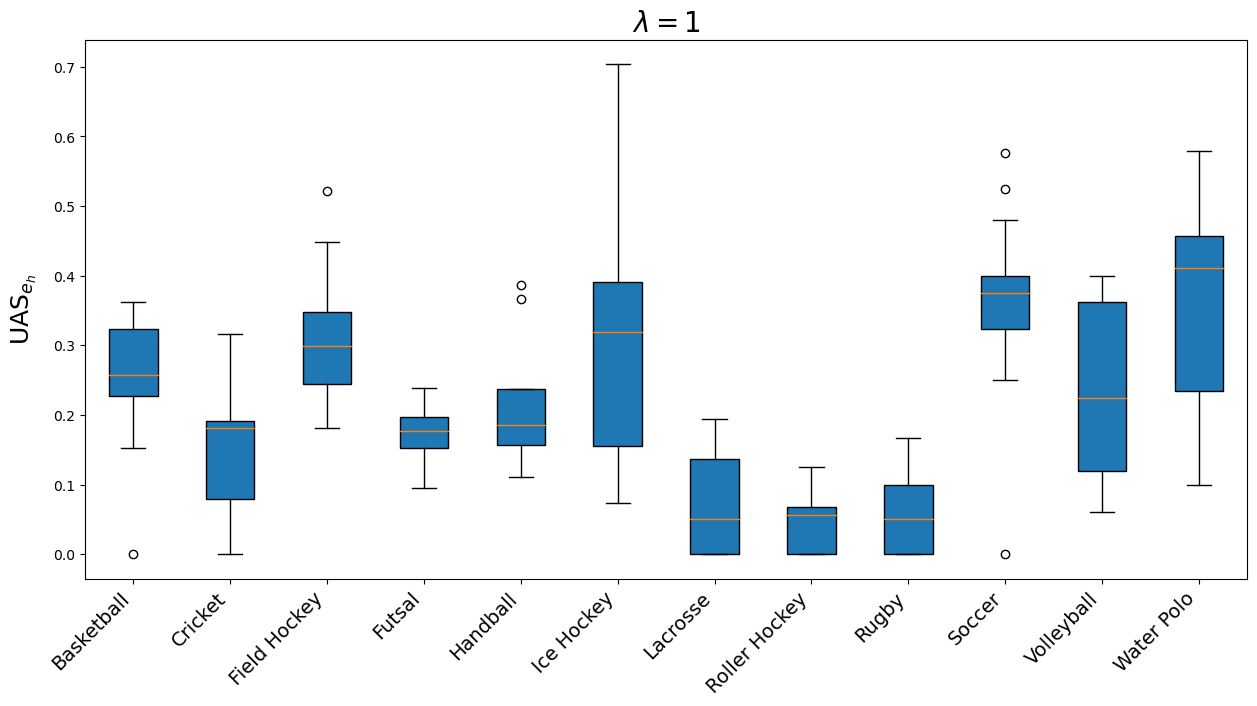

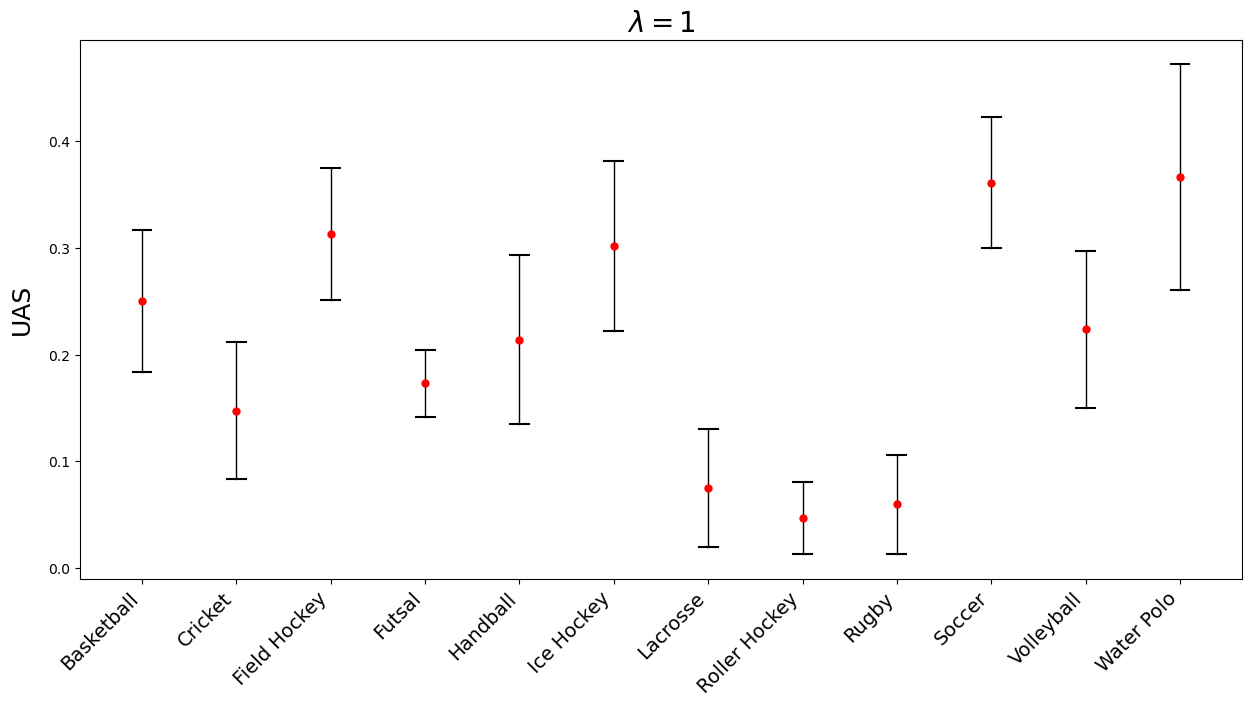


Kruskal-Wallis test results:
Statistic: 68.38612199284405
p-value: 2.473039524871451e-10

Pairwise Dunn's test results with Bonferroni correction:
               basketball   cricket  field_hockey    futsal  handball  \
basketball       1.000000  1.000000      1.000000  1.000000       1.0   
cricket          1.000000  1.000000      0.413350  1.000000       1.0   
field_hockey     1.000000  0.413350      1.000000  1.000000       1.0   
futsal           1.000000  1.000000      1.000000  1.000000       1.0   
handball         1.000000  1.000000      1.000000  1.000000       1.0   
ice_hockey       1.000000  0.713083      1.000000  1.000000       1.0   
lacrosse         0.316815  1.000000      0.009378  1.000000       1.0   
roller_hockey    0.103701  1.000000      0.002878  1.000000       1.0   
rugby            0.195328  1.000000      0.006487  1.000000       1.0   
soccer           1.000000  0.012727      1.000000  0.227035       1.0   
volleyball       1.000000  1.000000      1.000000

In [24]:
sp.plots(strategy="1v1", wranking=True, write_file=False)

In [25]:
print("Total duration = ", time.time() - previous_time)

Total duration =  0.638355016708374
